In [1]:
# installing packages
import sys
sys.path.append("../../bankruptcy_prediction")
import pandas as pd
import numpy as np
import sys
# for visualisation
import plotly.io as pio
pio.templates.default = "plotly_dark"
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt


# for modelling 
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from scipy.stats import pointbiserialr
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder

import optuna
import imblearn as imb
from collections import Counter

from sklearn.metrics import (PrecisionRecallDisplay, precision_score,
recall_score,confusion_matrix,f1_score)
from sklearn.model_selection import train_test_split
import shap
from utils import (get_shap_feat_importance,check_missing, 
plot_dist_bar, get_dist, read_xlsx, model_performance)


In [27]:
training_data = pd.read_csv("../data/training_data.csv")
testing_data = pd.read_csv("../data/testing_data.csv")
target="bankruptcy"
data = pd.concat([training_data,testing_data],axis=0).reset_index(drop=True)
print("Original Data Shape",data.shape)

data["company type"] = data["company type"].astype("category")

holdout=data.iloc[:50,:]
data = data.iloc[50:,:] 
print("Shape after dropping",data.shape)
X,y = data.drop(target,axis=1),data[target]

#Holdout
print("Shape of holdout",holdout.shape)
print(Counter(holdout[target]))

Original Data Shape (6811, 96)
Shape after dropping (6761, 96)
Shape of holdout (50, 96)
Counter({0: 47, 1: 3})


In [3]:
# define oversampling strategy
# oversample = RandomOverSampler(sampling_strategy='minority')
oversample = imb.over_sampling.RandomOverSampler(sampling_strategy=0.10)
# fit and apply the transform
X_over, y_over = oversample.fit_resample(X, y)
print(Counter(y_over))


Counter({0: 6564, 1: 656})


In [4]:
X_train,X_test,y_train,y_test = \
    train_test_split(X_over,y_over,test_size=0.3, stratify=y_over,random_state=42)

In [5]:
# X_train,y_train = training_data.drop("bankruptcy",axis = 1),training_data['bankruptcy']
# X_test,y_test = testing_data.drop("bankruptcy",axis = 1),testing_data['bankruptcy']
print(Counter(y_train))
print(Counter(y_test))

Counter({0: 4595, 1: 459})
Counter({0: 1969, 1: 197})


### Benchmark Model

Precision_Score: 0.1530880420499343,                Recall Score: 0.5076252723311547,                f1_score: 0.23523472993437655,
                confusion matrix: 
[[3306 1289]
 [ 226  233]]
                classification report: 
              precision    recall  f1-score   support

           0       0.94      0.72      0.81      4595
           1       0.15      0.51      0.24       459

    accuracy                           0.70      5054
   macro avg       0.54      0.61      0.52      5054
weighted avg       0.86      0.70      0.76      5054

Precision_Score: 0.14754098360655737,                Recall Score: 0.45685279187817257,                f1_score: 0.22304832713754644,
                confusion matrix: 
[[1449  520]
 [ 107   90]]
                classification report: 
              precision    recall  f1-score   support

           0       0.93      0.74      0.82      1969
           1       0.15      0.46      0.22       197

    accuracy                           

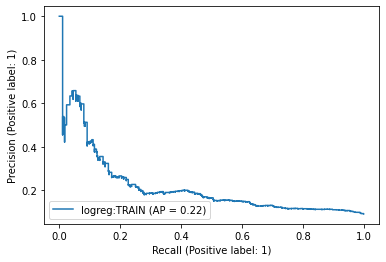

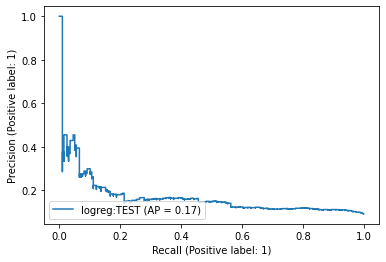

In [6]:
ohe = OneHotEncoder()
cat_cols = ["company type"]
X_train_ohe = ohe.fit_transform(X_train[cat_cols]).toarray()
X_test_ohe = ohe.transform(X_test[cat_cols]).toarray()

X_train_lr = X_train.drop(cat_cols,axis=1).copy(deep=True)
X_test_lr = X_test.drop(cat_cols,axis=1).copy(deep=True)

X_train_lr[ohe.categories_[0]] = X_train_ohe
X_test_lr[ohe.categories_[0]] = X_test_ohe


benchmark_mod = LogisticRegression(class_weight="balanced")
benchmark_mod.fit(X_train_lr,y_train)

pred_train_lr = benchmark_mod.predict_proba(X_train_lr)
pred_test_lr = benchmark_mod.predict_proba(X_test_lr)

model_performance(y_pred=pred_train_lr,y_true=y_train,threshold=0.5,
title="logreg:TRAIN",model_type="logreg")

model_performance(y_pred=pred_test_lr,y_true=y_test,threshold=0.5,
title="logreg:TEST",model_type="logreg")

In [7]:

def full_data(trial):

    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 4, 10),
        #"num_leaves": trial.suggest_int("num_leaves", 4, 20),
        "iterations":trial.suggest_int("iterations", 10,20),
        "l2_leaf_reg":trial.suggest_int("l2_leaf_reg", 2,10),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli","MVS"]
        )
    }

    if param["objective"] == "LogLoss":
        #"scale_pos_weight":y_train.value_counts()[0]/y_train.value_counts()[1],
        param["auto_class_weights"]="Balanced"

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    gbm = CatBoostClassifier(**param)

    gbm.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, 
    early_stopping_rounds=10,cat_features=["company type"]
    )

    preds = gbm.predict(X_test)
    pred_labels = np.rint(preds)
    f_one_score = f1_score(y_test, pred_labels)
    return f_one_score

In [8]:
study1 = optuna.create_study(direction="maximize")
study1.optimize(full_data, n_trials=50, timeout=600)

[I 2022-07-17 13:19:34,164] A new study created in memory with name: no-name-7b19c78e-d618-42f4-8a98-ab4129f6adac
[I 2022-07-17 13:19:34,632] Trial 0 finished with value: 0.5306122448979591 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.030054580590987492, 'learning_rate': 0.09352087597075914, 'depth': 6, 'iterations': 18, 'l2_leaf_reg': 2, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 8.95779790157702}. Best is trial 0 with value: 0.5306122448979591.
[I 2022-07-17 13:19:35,198] Trial 1 finished with value: 0.5418060200668896 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.06042252286890145, 'learning_rate': 0.05511482116590314, 'depth': 8, 'iterations': 19, 'l2_leaf_reg': 2, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.2864403730070527}. Best is trial 1 with value: 0.5418060200668896.
[I 2022-07-17 13:19:36,170] Trial 2 finished with value: 0.42857142857142855 and parameters: {'objective':

In [9]:
print("Number of finished trials: {}".format(len(study1.trials)))

print("Best trial:")
trial = study1.best_trial

print("  Value: {}".format(trial.value))

best_params={}
print("  Params: ")
for key, value in trial.params.items():
    best_params[key]=value
print(best_params)

Number of finished trials: 50
Best trial:
  Value: 0.7308781869688384
  Params: 
{'objective': 'Logloss', 'colsample_bylevel': 0.08697306481838464, 'learning_rate': 0.09439556641379884, 'depth': 9, 'iterations': 20, 'l2_leaf_reg': 4, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}


In [10]:
extra_params = {"cat_features":["company type"],
    #scale_pos_weight is supported only for binary classification Logloss loss
    #"scale_pos_weight":y_train.value_counts()[0]/y_train.value_counts()[1] 
    "auto_class_weights":"Balanced"
    }
best_params = {**best_params, **extra_params}


In [11]:
mod2 = CatBoostClassifier(**best_params)

mod2.fit(X_train,y_train)

# Get predicted probabilities for each class
pred_train_cat = mod2.predict_proba(X_train)
pred_test_cat = mod2.predict_proba(X_test)

0:	learn: 0.5831286	total: 82.6ms	remaining: 1.57s
1:	learn: 0.5011689	total: 309ms	remaining: 2.78s
2:	learn: 0.4534243	total: 381ms	remaining: 2.16s
3:	learn: 0.4115399	total: 560ms	remaining: 2.24s
4:	learn: 0.3688104	total: 655ms	remaining: 1.97s
5:	learn: 0.3318236	total: 750ms	remaining: 1.75s
6:	learn: 0.3059266	total: 892ms	remaining: 1.66s
7:	learn: 0.2820109	total: 974ms	remaining: 1.46s
8:	learn: 0.2590121	total: 1.09s	remaining: 1.33s
9:	learn: 0.2450711	total: 1.15s	remaining: 1.15s
10:	learn: 0.2273419	total: 1.21s	remaining: 993ms
11:	learn: 0.2145131	total: 1.36s	remaining: 906ms
12:	learn: 0.2056347	total: 1.44s	remaining: 776ms
13:	learn: 0.1987893	total: 1.5s	remaining: 641ms
14:	learn: 0.1894601	total: 1.57s	remaining: 523ms
15:	learn: 0.1819630	total: 1.71s	remaining: 427ms
16:	learn: 0.1703076	total: 1.81s	remaining: 320ms
17:	learn: 0.1655452	total: 1.91s	remaining: 212ms
18:	learn: 0.1595379	total: 1.96s	remaining: 103ms
19:	learn: 0.1560231	total: 2.04s	remaini

Precision_Score: 0.5945241199478487,                Recall Score: 0.9934640522875817,                f1_score: 0.7438825448613375,
                confusion matrix: 
[[4284  311]
 [   3  456]]
                classification report: 
              precision    recall  f1-score   support

           0       1.00      0.93      0.96      4595
           1       0.59      0.99      0.74       459

    accuracy                           0.94      5054
   macro avg       0.80      0.96      0.85      5054
weighted avg       0.96      0.94      0.94      5054

Precision_Score: 0.5692771084337349,                Recall Score: 0.9593908629441624,                f1_score: 0.7145557655954632,
                confusion matrix: 
[[1826  143]
 [   8  189]]
                classification report: 
              precision    recall  f1-score   support

           0       1.00      0.93      0.96      1969
           1       0.57      0.96      0.71       197

    accuracy                           0.93

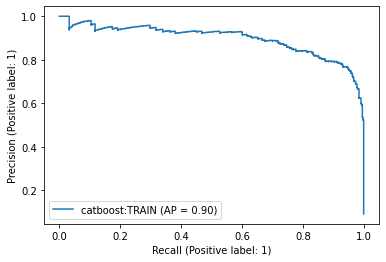

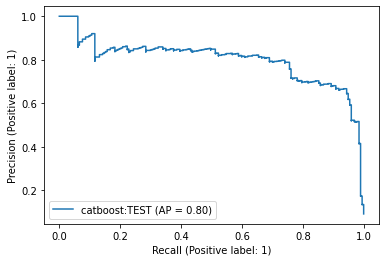

In [12]:
model_performance(y_pred=pred_train_cat,y_true=y_train,threshold=0.5,
title="catboost:TRAIN",model_type="catboost")

model_performance(y_pred=pred_test_cat,y_true=y_test,threshold=0.5,
title="catboost:TEST",model_type="catboost")


In [13]:
explainer2 = shap.TreeExplainer(mod2)
shap_values2 = explainer2.shap_values(X_train)

In [14]:
top=60
importance_mod2 = get_shap_feat_importance(shap_values2,X_train)
importance_topk = importance_mod2[importance_mod2["shap_importance"]>0][:top]
best_feat = importance_topk.features.values

In [15]:
fig = go.Figure([go.Bar(x=importance_topk.features, y=importance_topk.shap_importance)])
fig.update_layout(width=1200, height=500,xaxis_tickangle=-90, title="topk SHAP Importance")


In [16]:
if X_train[best_feat].select_dtypes(exclude=np.number).shape[1]>0:
    print(f"categorical feature detected")
else: 
    print(f"NO categorical feature detected")

NO categorical feature detected


In [17]:

def obj_best_feat(trial):

    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 4, 10),
        #"num_leaves": trial.suggest_int("num_leaves", 4, 20),
        "iterations":trial.suggest_int("iterations", 10,20),
        "l2_leaf_reg":trial.suggest_int("l2_leaf_reg", 2,10),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli","MVS"]
        )
    }

    # if param["objective"] == "LogLoss":
    #     #"scale_pos_weight":y_train.value_counts()[0]/y_train.value_counts()[1],
    #     param["auto_class_weights"]="Balanced"

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    gbm = CatBoostClassifier(**param)

    gbm.fit(X_train[best_feat], y_train, eval_set=[(X_test[best_feat], y_test)], verbose=0, 
    early_stopping_rounds=10#,cat_features=["company type"]
    )

    preds = gbm.predict(X_test[best_feat])
    pred_labels = np.rint(preds)
    f_one_score = f1_score(y_test, pred_labels)
    return f_one_score

In [18]:
study2 = optuna.create_study(direction="maximize")
study2.optimize(obj_best_feat, n_trials=50, timeout=600)

[I 2022-07-17 13:20:16,476] A new study created in memory with name: no-name-3a0b04bb-72d1-4672-985c-c08f82b5bfb6
[I 2022-07-17 13:20:16,620] Trial 0 finished with value: 0.0 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.010342215674159664, 'learning_rate': 0.05067936391669443, 'depth': 7, 'iterations': 15, 'l2_leaf_reg': 2, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.2987442888684573}. Best is trial 0 with value: 0.0.
[I 2022-07-17 13:20:16,830] Trial 1 finished with value: 0.0 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.011673919633035183, 'learning_rate': 0.05932287371139472, 'depth': 8, 'iterations': 20, 'l2_leaf_reg': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.552438754355183}. Best is trial 0 with value: 0.0.
[I 2022-07-17 13:20:17,013] Trial 2 finished with value: 0.30769230769230765 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.07216545284094

In [19]:
print("Number of finished trials: {}".format(len(study2.trials)))

print("Best trial:")
trial2 = study2.best_trial

print("  Value: {}".format(trial2.value))

best_params2={}
print("  Params: ")
for key, value in trial2.params.items():
    best_params2[key]=value
print(best_params2)

Number of finished trials: 50
Best trial:
  Value: 0.7188405797101449
  Params: 
{'objective': 'Logloss', 'colsample_bylevel': 0.08273051529956442, 'learning_rate': 0.08698932274609525, 'depth': 9, 'iterations': 19, 'l2_leaf_reg': 3, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}


In [20]:
extra_params = {
    #"cat_features":["company type"],
    #scale_pos_weight is supported only for binary classification Logloss loss
    #"scale_pos_weight":y_train.value_counts()[0]/y_train.value_counts()[1] 
    #"auto_class_weights":"Balanced"
    }

best_params2 = {**best_params2, **extra_params}

In [21]:
mod3 = CatBoostClassifier(**best_params2)

mod3.fit(X_train[best_feat],y_train)

# Get predicted probabilities for each class
pred_train_cat3 = mod3.predict_proba(X_train[best_feat])
pred_test_cat3 = mod3.predict_proba(X_test[best_feat])

0:	learn: 0.5475267	total: 56.8ms	remaining: 1.02s
1:	learn: 0.4323812	total: 95.9ms	remaining: 815ms
2:	learn: 0.3567725	total: 129ms	remaining: 690ms
3:	learn: 0.3074185	total: 133ms	remaining: 497ms
4:	learn: 0.2667475	total: 180ms	remaining: 505ms
5:	learn: 0.2345443	total: 228ms	remaining: 495ms
6:	learn: 0.2099096	total: 269ms	remaining: 461ms
7:	learn: 0.1909203	total: 312ms	remaining: 429ms
8:	learn: 0.1798175	total: 353ms	remaining: 392ms
9:	learn: 0.1661472	total: 371ms	remaining: 334ms
10:	learn: 0.1549004	total: 400ms	remaining: 291ms
11:	learn: 0.1444886	total: 428ms	remaining: 250ms
12:	learn: 0.1353838	total: 468ms	remaining: 216ms
13:	learn: 0.1301142	total: 516ms	remaining: 184ms
14:	learn: 0.1254040	total: 561ms	remaining: 150ms
15:	learn: 0.1196801	total: 600ms	remaining: 112ms
16:	learn: 0.1141770	total: 636ms	remaining: 74.9ms
17:	learn: 0.1109095	total: 686ms	remaining: 38.1ms
18:	learn: 0.1071412	total: 736ms	remaining: 0us


Precision_Score: 0.9246376811594202,                Recall Score: 0.6949891067538126,                f1_score: 0.7935323383084577,
                confusion matrix: 
[[4569   26]
 [ 140  319]]
                classification report: 
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      4595
           1       0.92      0.69      0.79       459

    accuracy                           0.97      5054
   macro avg       0.95      0.84      0.89      5054
weighted avg       0.97      0.97      0.97      5054

Precision_Score: 0.8378378378378378,                Recall Score: 0.6294416243654822,                f1_score: 0.7188405797101449,
                confusion matrix: 
[[1945   24]
 [  73  124]]
                classification report: 
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1969
           1       0.84      0.63      0.72       197

    accuracy                           0.96

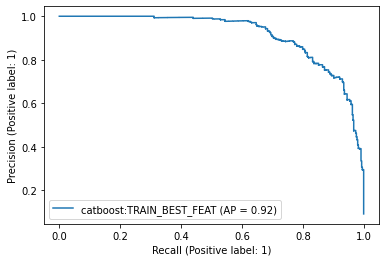

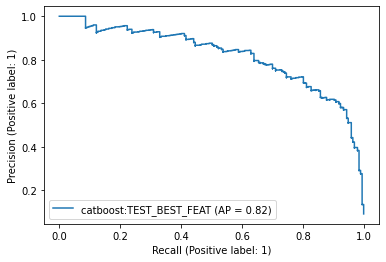

In [22]:
model_performance(y_pred=pred_train_cat3,y_true=y_train,threshold=0.5,
title="catboost:TRAIN_BEST_FEAT",model_type="catboost")

model_performance(y_pred=pred_test_cat3,y_true=y_test,threshold=0.5,
title="catboost:TEST_BEST_FEAT",model_type="catboost")


Precision_Score: 0.0,                Recall Score: 0.0,                f1_score: 0.0,
                confusion matrix: 
[[47  0]
 [ 3  0]]
                classification report: 
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        47
           1       0.00      0.00      0.00         3

    accuracy                           0.94        50
   macro avg       0.47      0.50      0.48        50
weighted avg       0.88      0.94      0.91        50



/Users/convergeml/engineering/casestudy/bankruptcy_prediction/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/convergeml/engineering/casestudy/bankruptcy_prediction/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/convergeml/engineering/casestudy/bankruptcy_prediction/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/convergeml/engineering/casestudy/bankruptcy_prediction/.venv/lib/pyth

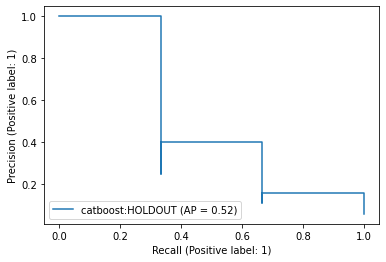

In [28]:
holdout_df = holdout.drop(target,axis = 1)[best_feat]
pred_holdout_cat = mod3.predict_proba(holdout_df)
model_performance(y_pred=pred_holdout_cat,y_true=holdout[target],threshold=0.5,
title="catboost:HOLDOUT",model_type="catboost")
